<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S10_AssignmentFinalSolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Add Library Path in your def search path**

In [2]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   all.py	       execute.py    __pycache__
AlbTrainTransforms.py  DataLoaders.py  Gradcam.py    resNet.py
albumentations.py      displayData.py  LR_Finder.py  rohan_library.py


In [0]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [4]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gc
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
import LR_Finder as lrf

  pip install torch-lr-finder -v --global-option="amp"


REQUIRED LIBRARIES LOADED...


**Albumentations**

In [0]:
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [6]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [0]:
dl = loader.DataLoaders()
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [8]:
dataiter = iter(trainLoader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 3, 32, 32])
torch.Size([128])


**Displaying Random Images**

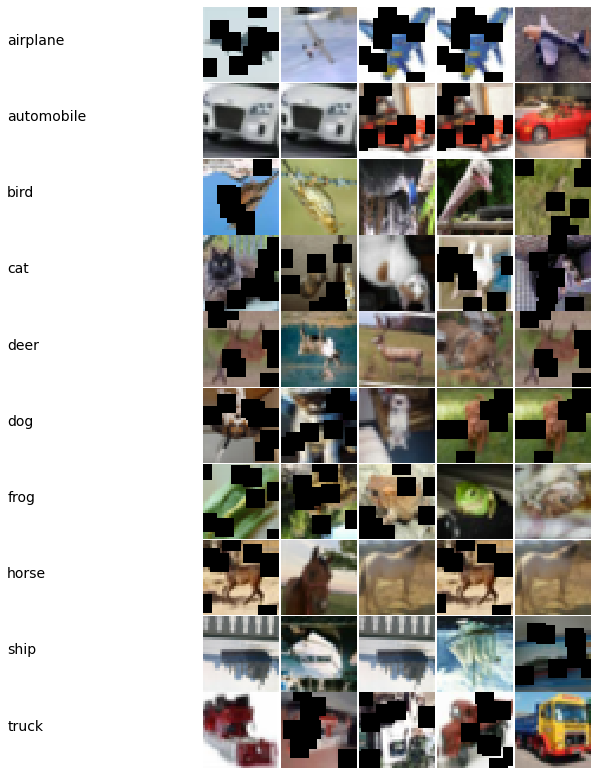

In [9]:
display.classImages(trainLoader)

**Model Summary**

In [10]:
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = ResNet18().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-1

**LR Finder**

In [11]:
criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrf.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainLoader, end_lr=100, num_iter=100, step_mode="exp")

The loss has diverged, Stopping Early!


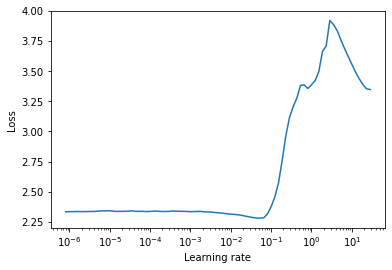

In [12]:
lr_finder.plot()# best lr is in b/w 0.009 and 0.1

In [0]:
lr_finder.reset()

**Modelling**

In [22]:
incorrectSamples = []
correctSamples = []
correctLabels = []
model = ResNet18().to(device)


criterion = execute.cross_entropy_loss()
optimizer = optim.SGD(model.parameters(), lr = 0.009, momentum=0.9, weight_decay=1e-4, nesterov = True) 
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'max', patience=2, factor = 0.9, verbose=True)


model1 = execute.Test_Train(model, device, optimizer, criterion)
EPOCHS = 50


for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda = 1e-5 )
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  scheduler.step(model1.test_losses[-1])
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = param_group['lr'], e=epoch+1))

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH:  1


Loss=2.3675975799560547 Batch_id=390 Accuracy=41.75: 100%|██████████| 391/391 [01:08<00:00,  5.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.4670).  Saving model ...

Test set: Average loss: 1.4670, Accuracy: 5028/10000 (50.28%)

Learning Rate = 0.009 for EPOCH 2
EPOCH:  2


Loss=2.365196704864502 Batch_id=390 Accuracy=55.82: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.4670 --> 1.0642).  Saving model ...

Test set: Average loss: 1.0642, Accuracy: 5714/10000 (57.14%)

Learning Rate = 0.009 for EPOCH 3
EPOCH:  3


Loss=2.058218002319336 Batch_id=390 Accuracy=62.35: 100%|██████████| 391/391 [01:07<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (1.0642 --> 0.5306).  Saving model ...

Test set: Average loss: 0.5306, Accuracy: 6751/10000 (67.51%)

Learning Rate = 0.009 for EPOCH 4
EPOCH:  4


Loss=2.0560193061828613 Batch_id=390 Accuracy=66.65: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7899, Accuracy: 7069/10000 (70.69%)

Epoch     4: reducing learning rate of group 0 to 8.1000e-03.
Learning Rate = 0.0081 for EPOCH 5
EPOCH:  5


Loss=1.750598430633545 Batch_id=390 Accuracy=70.42: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.5306 --> 0.4687).  Saving model ...

Test set: Average loss: 0.4687, Accuracy: 7368/10000 (73.68%)

Learning Rate = 0.0081 for EPOCH 6
EPOCH:  6


Loss=1.669581413269043 Batch_id=390 Accuracy=72.59: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7804, Accuracy: 7423/10000 (74.23%)

Learning Rate = 0.0081 for EPOCH 7
EPOCH:  7


Loss=1.70284104347229 Batch_id=390 Accuracy=74.44: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.4687 --> 0.3845).  Saving model ...

Test set: Average loss: 0.3845, Accuracy: 7568/10000 (75.68%)

Epoch     7: reducing learning rate of group 0 to 7.2900e-03.
Learning Rate = 0.00729 for EPOCH 8
EPOCH:  8


Loss=1.6945821046829224 Batch_id=390 Accuracy=75.97: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7223, Accuracy: 7575/10000 (75.75%)

Learning Rate = 0.00729 for EPOCH 9
EPOCH:  9


Loss=1.3768842220306396 Batch_id=390 Accuracy=77.52: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6119, Accuracy: 7890/10000 (78.90%)

Learning Rate = 0.00729 for EPOCH 10
EPOCH:  10


Loss=1.397733211517334 Batch_id=390 Accuracy=78.63: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6161, Accuracy: 8011/10000 (80.11%)

Epoch    10: reducing learning rate of group 0 to 6.5610e-03.
Learning Rate = 0.006561 for EPOCH 11
EPOCH:  11


Loss=1.4087979793548584 Batch_id=390 Accuracy=80.08: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5111, Accuracy: 8141/10000 (81.41%)

Learning Rate = 0.006561 for EPOCH 12
EPOCH:  12


Loss=1.496985673904419 Batch_id=390 Accuracy=80.83: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.3845 --> 0.3187).  Saving model ...

Test set: Average loss: 0.3187, Accuracy: 7942/10000 (79.42%)

Learning Rate = 0.006561 for EPOCH 13
EPOCH:  13


Loss=1.2488068342208862 Batch_id=390 Accuracy=81.29: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5716, Accuracy: 7935/10000 (79.35%)

Epoch    13: reducing learning rate of group 0 to 5.9049e-03.
Learning Rate = 0.0059049 for EPOCH 14
EPOCH:  14


Loss=1.291659951210022 Batch_id=390 Accuracy=82.45: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3288, Accuracy: 8087/10000 (80.87%)

Learning Rate = 0.0059049 for EPOCH 15
EPOCH:  15


Loss=1.232123613357544 Batch_id=390 Accuracy=83.00: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5269, Accuracy: 8176/10000 (81.76%)

Learning Rate = 0.0059049 for EPOCH 16
EPOCH:  16


Loss=1.4186363220214844 Batch_id=390 Accuracy=83.48: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3855, Accuracy: 8337/10000 (83.37%)

Epoch    16: reducing learning rate of group 0 to 5.3144e-03.
Learning Rate = 0.00531441 for EPOCH 17
EPOCH:  17


Loss=1.2570610046386719 Batch_id=390 Accuracy=84.23: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]

Validation loss has  decreased (0.3187 --> 0.0328).  Saving model ...

Test set: Average loss: 0.0328, Accuracy: 8289/10000 (82.89%)

Learning Rate = 0.00531441 for EPOCH 18
EPOCH:  18


Loss=1.0890611410140991 Batch_id=390 Accuracy=84.88: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9010, Accuracy: 8295/10000 (82.95%)

Learning Rate = 0.00531441 for EPOCH 19
EPOCH:  19


Loss=1.1557908058166504 Batch_id=390 Accuracy=84.93: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7350, Accuracy: 8349/10000 (83.49%)

Epoch    19: reducing learning rate of group 0 to 4.7830e-03.
Learning Rate = 0.004782969000000001 for EPOCH 20
EPOCH:  20


Loss=1.2561291456222534 Batch_id=390 Accuracy=85.92: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1049, Accuracy: 8313/10000 (83.13%)

Learning Rate = 0.004782969000000001 for EPOCH 21
EPOCH:  21


Loss=1.197932243347168 Batch_id=390 Accuracy=85.82: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3069, Accuracy: 8436/10000 (84.36%)

Learning Rate = 0.004782969000000001 for EPOCH 22
EPOCH:  22


Loss=1.024240493774414 Batch_id=390 Accuracy=86.50: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4511, Accuracy: 8486/10000 (84.86%)

Epoch    22: reducing learning rate of group 0 to 4.3047e-03.
Learning Rate = 0.0043046721 for EPOCH 23
EPOCH:  23


Loss=1.1397984027862549 Batch_id=390 Accuracy=87.10: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.6135, Accuracy: 8556/10000 (85.56%)

Learning Rate = 0.0043046721 for EPOCH 24
EPOCH:  24


Loss=1.0556340217590332 Batch_id=390 Accuracy=87.66: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2905, Accuracy: 8505/10000 (85.05%)

Learning Rate = 0.0043046721 for EPOCH 25
EPOCH:  25


Loss=0.9285809993743896 Batch_id=390 Accuracy=87.81: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4634, Accuracy: 8650/10000 (86.50%)

Learning Rate = 0.0043046721 for EPOCH 26
EPOCH:  26


Loss=0.9378054141998291 Batch_id=390 Accuracy=87.92: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4900, Accuracy: 8641/10000 (86.41%)

Epoch    26: reducing learning rate of group 0 to 3.8742e-03.
Learning Rate = 0.0038742048900000004 for EPOCH 27
EPOCH:  27


Loss=0.9665704369544983 Batch_id=390 Accuracy=88.56: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6541, Accuracy: 8632/10000 (86.32%)

Learning Rate = 0.0038742048900000004 for EPOCH 28
EPOCH:  28


Loss=0.9599876999855042 Batch_id=390 Accuracy=89.09: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8136, Accuracy: 8407/10000 (84.07%)

Learning Rate = 0.0038742048900000004 for EPOCH 29
EPOCH:  29


Loss=1.0347962379455566 Batch_id=390 Accuracy=88.85: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1317, Accuracy: 8398/10000 (83.98%)

Epoch    29: reducing learning rate of group 0 to 3.4868e-03.
Learning Rate = 0.0034867844010000003 for EPOCH 30
EPOCH:  30


Loss=0.9723654389381409 Batch_id=390 Accuracy=89.46: 100%|██████████| 391/391 [01:06<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.1401, Accuracy: 8666/10000 (86.66%)

Learning Rate = 0.0034867844010000003 for EPOCH 31
EPOCH:  31


Loss=0.9641888737678528 Batch_id=390 Accuracy=89.82: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2646, Accuracy: 8691/10000 (86.91%)

Learning Rate = 0.0034867844010000003 for EPOCH 32
EPOCH:  32


Loss=0.9840719699859619 Batch_id=390 Accuracy=89.93: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5090, Accuracy: 8577/10000 (85.77%)

Epoch    32: reducing learning rate of group 0 to 3.1381e-03.
Learning Rate = 0.0031381059609 for EPOCH 33
EPOCH:  33


Loss=0.9356463551521301 Batch_id=390 Accuracy=90.27: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2999, Accuracy: 8811/10000 (88.11%)

Learning Rate = 0.0031381059609 for EPOCH 34
EPOCH:  34


Loss=0.8016268014907837 Batch_id=390 Accuracy=90.64: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3230, Accuracy: 8720/10000 (87.20%)

Learning Rate = 0.0031381059609 for EPOCH 35
EPOCH:  35


Loss=0.8207629323005676 Batch_id=390 Accuracy=90.67: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4417, Accuracy: 8772/10000 (87.72%)

Epoch    35: reducing learning rate of group 0 to 2.8243e-03.
Learning Rate = 0.00282429536481 for EPOCH 36
EPOCH:  36


Loss=0.9156296253204346 Batch_id=390 Accuracy=91.05: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7140, Accuracy: 8665/10000 (86.65%)

Learning Rate = 0.00282429536481 for EPOCH 37
EPOCH:  37


Loss=0.8067395091056824 Batch_id=390 Accuracy=91.46: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3792, Accuracy: 8772/10000 (87.72%)

Learning Rate = 0.00282429536481 for EPOCH 38
EPOCH:  38


Loss=0.9219717979431152 Batch_id=390 Accuracy=91.49: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2212, Accuracy: 8760/10000 (87.60%)

Epoch    38: reducing learning rate of group 0 to 2.5419e-03.
Learning Rate = 0.002541865828329 for EPOCH 39
EPOCH:  39


Loss=0.9472044110298157 Batch_id=390 Accuracy=91.89: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4446, Accuracy: 8766/10000 (87.66%)

Learning Rate = 0.002541865828329 for EPOCH 40
EPOCH:  40


Loss=0.7269800901412964 Batch_id=390 Accuracy=92.01: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2438, Accuracy: 8755/10000 (87.55%)

Learning Rate = 0.002541865828329 for EPOCH 41
EPOCH:  41


Loss=0.8501536846160889 Batch_id=390 Accuracy=92.16: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2971, Accuracy: 8868/10000 (88.68%)

Epoch    41: reducing learning rate of group 0 to 2.2877e-03.
Learning Rate = 0.0022876792454961 for EPOCH 42
EPOCH:  42


Loss=0.7903354167938232 Batch_id=390 Accuracy=92.59: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6438, Accuracy: 8859/10000 (88.59%)

Learning Rate = 0.0022876792454961 for EPOCH 43
EPOCH:  43


Loss=0.705917239189148 Batch_id=390 Accuracy=92.62: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.3594, Accuracy: 8766/10000 (87.66%)

Learning Rate = 0.0022876792454961 for EPOCH 44
EPOCH:  44


Loss=0.8390583395957947 Batch_id=390 Accuracy=92.72: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6713, Accuracy: 8767/10000 (87.67%)

Epoch    44: reducing learning rate of group 0 to 2.0589e-03.
Learning Rate = 0.00205891132094649 for EPOCH 45
EPOCH:  45


Loss=0.7062127590179443 Batch_id=390 Accuracy=92.92: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6009, Accuracy: 8838/10000 (88.38%)

Learning Rate = 0.00205891132094649 for EPOCH 46
EPOCH:  46


Loss=0.8726668357849121 Batch_id=390 Accuracy=93.16: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0911, Accuracy: 8864/10000 (88.64%)

Learning Rate = 0.00205891132094649 for EPOCH 47
EPOCH:  47


Loss=0.6966678500175476 Batch_id=390 Accuracy=93.10: 100%|██████████| 391/391 [01:07<00:00,  5.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.2770, Accuracy: 8837/10000 (88.37%)

Epoch    47: reducing learning rate of group 0 to 1.8530e-03.
Learning Rate = 0.001853020188851841 for EPOCH 48
EPOCH:  48


Loss=0.7848386764526367 Batch_id=390 Accuracy=93.52: 100%|██████████| 391/391 [01:07<00:00,  5.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6072, Accuracy: 8834/10000 (88.34%)

Learning Rate = 0.001853020188851841 for EPOCH 49
EPOCH:  49


Loss=0.6624087691307068 Batch_id=390 Accuracy=93.53: 100%|██████████| 391/391 [01:07<00:00,  5.84it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4730, Accuracy: 8874/10000 (88.74%)

Learning Rate = 0.001853020188851841 for EPOCH 50
EPOCH:  50


Loss=0.681330680847168 Batch_id=390 Accuracy=93.75: 100%|██████████| 391/391 [01:07<00:00,  5.83it/s]



Test set: Average loss: 0.4327, Accuracy: 8891/10000 (88.91%)

Epoch    50: reducing learning rate of group 0 to 1.6677e-03.
Learning Rate = 0.001667718169966657 for EPOCH 51


**Plot Train & Test Curves**

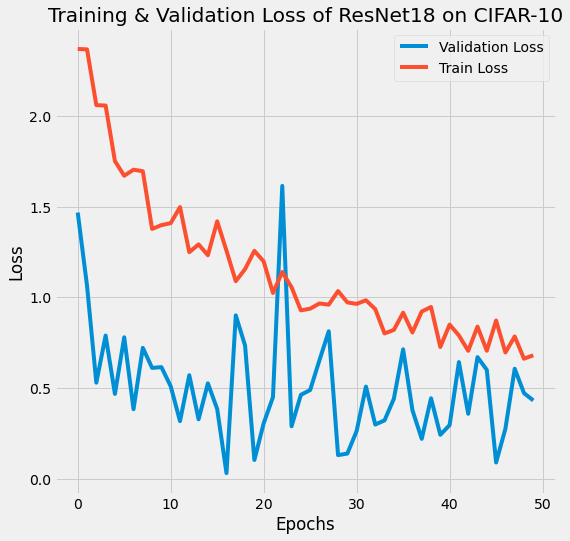

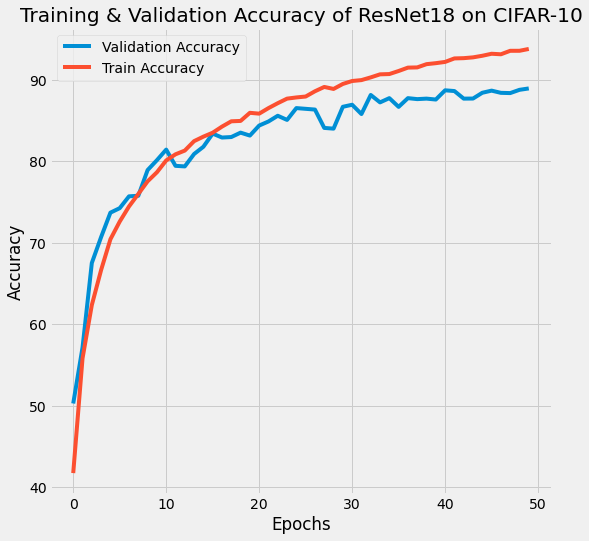

In [23]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on CIFAR-10', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on CIFAR-10')

**Misclassified Images**

<Figure size 936x936 with 0 Axes>

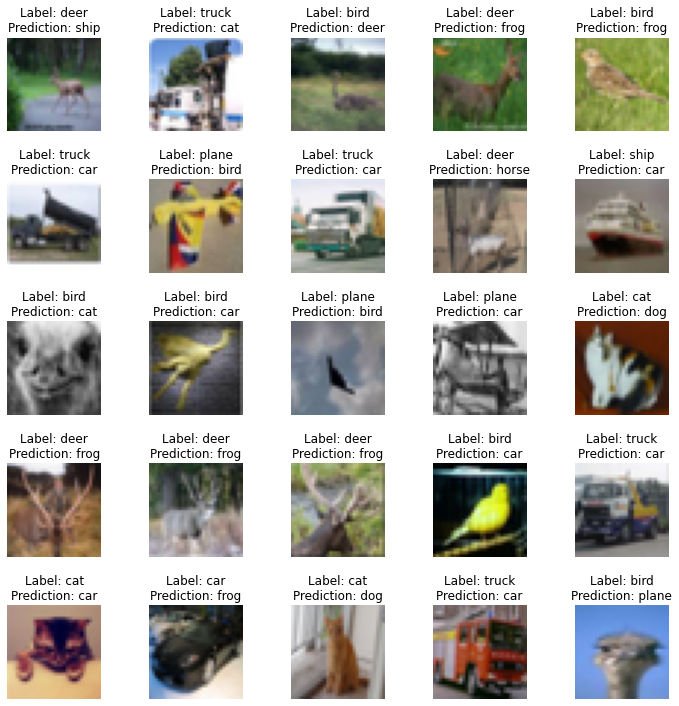

In [24]:
display.misclassifiedOnes(model, testLoader, incorrectSamples,'Misclassfied.png')

#GradCam Implementation

**GradCam Input Data**

In [0]:

images = [x['image'] for x in incorrectSamples[10:20]] # Extracting MisClassified Images
target_classes = [l['label'] for l in incorrectSamples[10:20]] # Target Classes
predicted_classes = [p['prediction'] for p in incorrectSamples[10:20]] # Predicted Classes

targetLabels = [classes[t] for t in target_classes] # Target Labels

predLabels = [classes[p] for p in predicted_classes] # Predicted Labels


**GradCam Core** 

torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


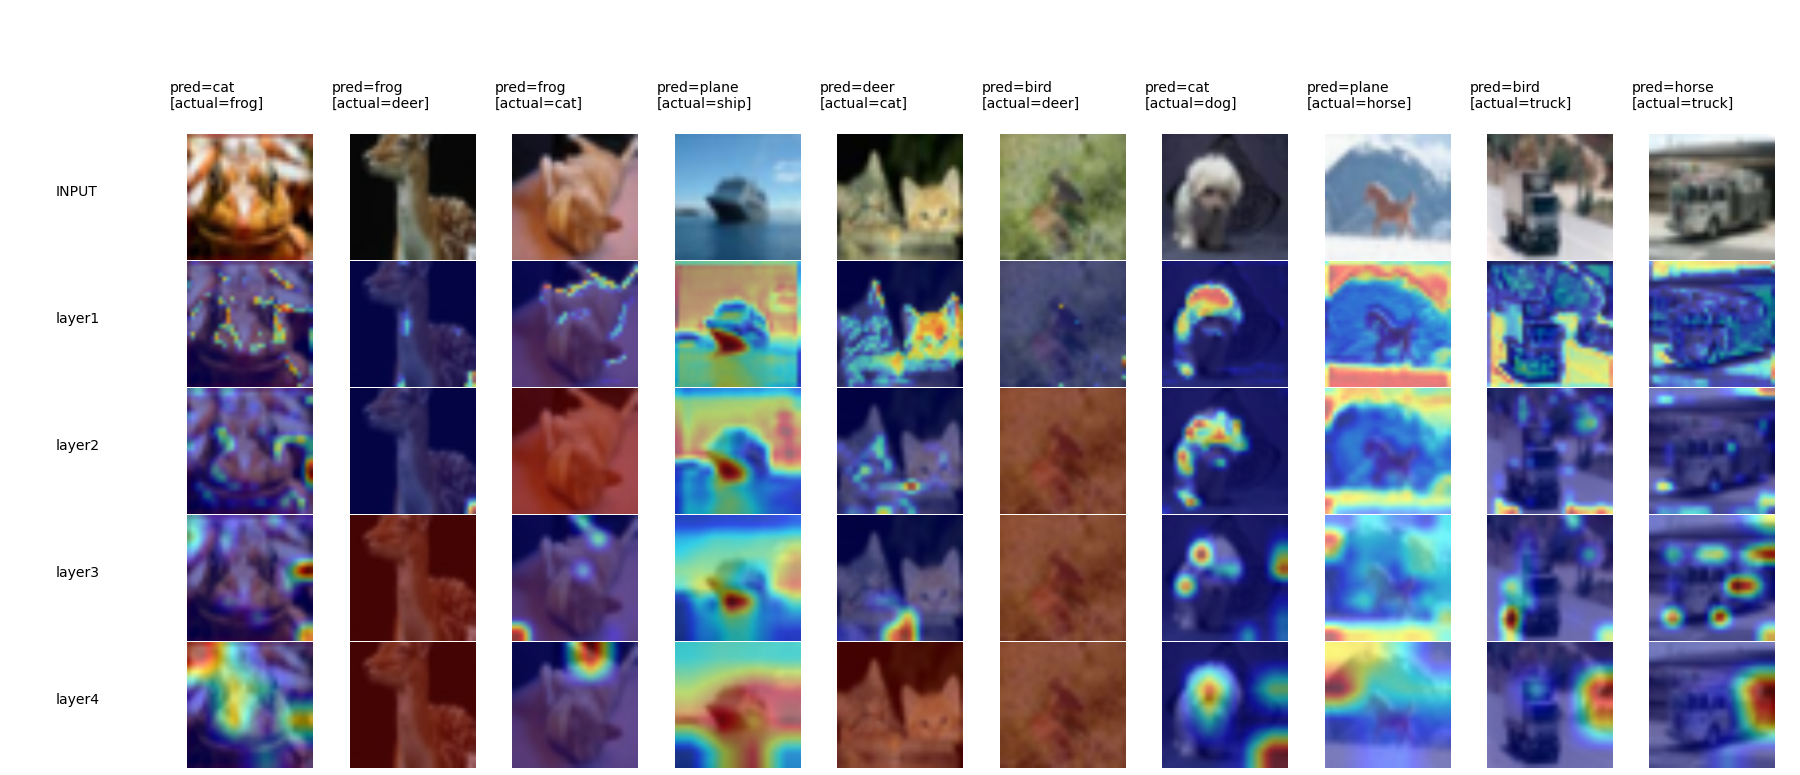

In [18]:

model = ResNet18().to(device)
image_size = (3,32,32) # set image size

target_layers = ["layer1", "layer2", "layer3", "layer4"]
gradcam_output, probs, predicted_classes = gc.GRADCAM(images, device, target_classes, model, target_layers) 

gc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, targetLabels, predLabels) # Plot the gradcam_output for the target layers
